In [31]:
import numpy as np
from typing import Callable
from functools import partial
import math
import matplotlib.pyplot as plt

In [32]:
class ExtendedKalmanFilter:
    def __init__(self, state_dim, measurement_dim, control_dim=0):
        self.state_dim = state_dim
        self.measurement_dim = measurement_dim
        self.control_dim = control_dim

        self.x = np.zeros((state_dim, 1))  # State estimate
        self.z = np.zeros((measurement_dim, 1))  # Measurement


        self.u = np.zeros((control_dim, 1))  # Control input
        self.G = np.eye(state_dim, control_dim) if control_dim > 0 else None  # Control matrix

        self.P = np.eye(state_dim)  # State covariance
        self.Q = np.eye(state_dim)  # Process noise
        self.R = np.eye(measurement_dim)  # Measurement noise

        self.K = np.zeros((state_dim, measurement_dim))  # Kalman gain

        self.fx: Callable = None
        self.hx: Callable = None

        self.df: Callable = None
        self.dh: Callable = None

        self.X_hist = []  # History of states
        self.P_hist = []  # History of covariances

    def set_transition_function(self, fx: Callable): self.fx = fx
    def set_measurement_function(self, hx: Callable): self.hx = hx
    def set_transition_derivation(self, df: Callable): self.df = df
    def set_measurement_derivation(self, dh: Callable): self.dh = dh
    def set_control_matrix(self, G): self.G = G
    def set_process_noise(self, Q): self.Q = Q
    def set_measurement_noise(self, R): self.R = R

    def state_extrapolation(self):
        if self.control_dim > 0 and self.G is not None:
            self.x = self.fx(self.x) + self.G @ self.u
        else:
            self.x = self.fx(self.x)

    def uncertainty_propagation(self):
        self.P = self.df(self.x) @ self.P @ self.df(self.x).T + self.Q

    def compute_kalman_gain(self):
        S = self.dh(self.x) @ self.P @ self.dh(self.x).T + self.R
        self.K = self.P @ self.dh(self.x).T @ np.linalg.inv(S)

    def update_estimate(self):
        self.x = self.x + self.K @ (self.z - self.hx(self.x))

    def update_uncertainty(self):
        I = np.eye(self.state_dim)
        a = I - self.K @ self.dh(self.x)
        self.P = a @ self.P @ a.T + self.K @ self.R @ self.K.T

    def predict(self, u=None):
        if u is not None:
            self.u = u.reshape(-1, 1)
        self.state_extrapolation()
        self.uncertainty_propagation()
        return self.x.copy(), self.P.copy()

    def correct(self, z):
        self.z = z.reshape(-1, 1)
        self.compute_kalman_gain()
        self.update_estimate()
        self.update_uncertainty()
        return self.x.copy(), self.P.copy()

    def initialize(self, x0, P0):
        self.x = x0.reshape(self.state_dim, 1)
        self.P = P0.reshape(self.state_dim, self.state_dim)

    def step(self, z, u=None):
        self.predict(u)
        self.correct(z)
        self.X_hist.append(self.x.copy())
        self.P_hist.append(self.P.copy())
        return self.x.copy(), self.P.copy()

	Estimated state:
 [ 316.99567216  -55.33720231  -18.44671785 -414.83004662  -76.55472535
  -25.51960272],
 	Estimated covariance:
 [[1.15754268e+02 7.71708836e+01 2.57249998e+01 5.07323833e-01
  3.38221902e-01 1.12746647e-01]
 [7.71708836e+01 5.51465948e+02 3.50507342e+02 3.38221902e-01
  2.25485276e-01 7.51657673e-02]
 [2.57249998e+01 3.50507342e+02 4.50193122e+02 1.12746647e-01
  7.51657673e-02 2.50565920e-02]
 [5.07323833e-01 3.38221902e-01 1.12746647e-01 9.29004511e+01
  6.19347351e+01 2.06460127e+01]
 [3.38221902e-01 2.25485276e-01 7.51657673e-02 6.19347351e+01
  5.41308335e+02 3.47121290e+02]
 [1.12746647e-01 7.51657673e-02 2.50565920e-02 2.06460127e+01
  3.47121290e+02 4.49064378e+02]]
	Estimated state:
 [ 317.8520717    -3.72437458   11.51942108 -376.63104087   38.88261848
   35.45486951],
 	Estimated covariance:
 [[147.47481815 158.16513602  67.68588764 -14.92450675 -16.61295562
   -7.20369102]
 [158.16513602 365.34623443 228.43797579 -16.0548901  -17.31486081
   -7.42474327]

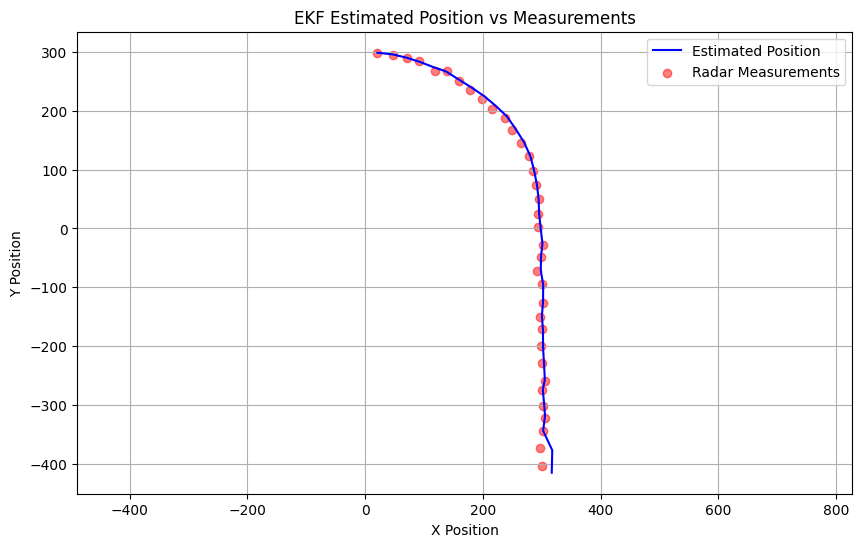

In [33]:
# Car 2D example with no control unit (a radar detects car position with angle phi and distance r)
state_dim = 6 # x, vx, ax, y, vy, ay

# measurement dim = 2 angle phi and distance r
measurement_dim = 2

# Extended Kalman Filter
ekf = ExtendedKalmanFilter(state_dim=state_dim, measurement_dim=measurement_dim)

def transition_function(x):
    F = np.array([[1, delta_t, 0.5 * delta_t**2, 0, 0, 0],
                [0, 1, delta_t, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, delta_t, 0.5 * delta_t**2],
                [0, 0, 0, 0, 1, delta_t],
                [0, 0, 0, 0, 0, 1]])
    return F @ x

def measurement_function(x):
    x = x.reshape(-1)
    r = np.sqrt(x[0]**2 + x[3]**2)
    phi = np.arctan2(x[3], x[0])  # atan2(y, x)
    return np.array([r, phi]).reshape(-1, 1)


def transition_derivation(x):
    F = np.array([[1, delta_t, 0.5 * delta_t**2, 0, 0, 0],
                [0, 1, delta_t, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, delta_t, 0.5 * delta_t**2],
                [0, 0, 0, 0, 1, delta_t],
                [0, 0, 0, 0, 0, 1]])
    return F

def measurement_derivation(x):
    x = x.reshape(-1)
    px = x[0]
    py = x[3]
    r2 = px**2 + py**2
    r = np.sqrt(r2)
    dr_dx = px / r
    dr_dy = py / r
    dphi_dx = -py / r2
    dphi_dy = px / r2

    H = np.array([
        [dr_dx, 0, 0, dr_dy, 0, 0],
        [dphi_dx, 0, 0, dphi_dy, 0, 0]
    ])
    return H


ekf.set_transition_derivation(transition_derivation)
ekf.set_measurement_derivation(measurement_derivation)
ekf.set_transition_function(transition_function)
ekf.set_measurement_function(measurement_function)

# define problem variables
delta_t = 1 # second
process_noise_std = 0.2 # m/s^2
measurement_noise_x = 5 # m
measurement_noise_y = 0.0087 # rad

# set uncorrelated process noise
ekf.set_process_noise(np.array([[delta_t**4 / 4, delta_t**3 / 2, delta_t**2 / 2, 0, 0, 0],
                               [delta_t**3 / 2, delta_t**2, delta_t, 0, 0, 0],
                               [delta_t**2 / 2, delta_t, 1, 0, 0, 0],
                               [0, 0, 0, delta_t**4 / 4, delta_t**3 / 2, delta_t**2 / 2],
                               [0, 0, 0, delta_t**3 / 2, delta_t**2, delta_t],
                               [0, 0, 0, delta_t**2 / 2, delta_t, 1]]) * process_noise_std**2)
# set uncorrelated measurement noise
ekf.set_measurement_noise(np.array([[measurement_noise_x**2, 0],
                                     [0, measurement_noise_y**2]]))

x0 = np.array([400, 0, 0, -300, 0, 0])
p0 = np.diag([500]*6)

ekf.initialize(x0, p0)


z = np.array([
    [502.55, -0.9316],
    [477.34, -0.8977],
    [457.21, -0.8512],
    [442.94, -0.8114],
    [427.27, -0.7853],
    [406.05, -0.7392],
    [400.73, -0.7052],
    [377.32, -0.6478],
    [360.27, -0.59],
    [345.93, -0.5183],
    [333.34, -0.4698],
    [328.07, -0.3952],
    [315.48, -0.3026],
    [301.41, -0.2445],
    [302.87, -0.1626],
    [304.25, -0.0937],
    [294.46, 0.0085],
    [294.29, 0.0856],
    [299.38, 0.1675],
    [299.37, 0.2467],
    [300.68, 0.329],
    [304.1, 0.4149],
    [301.96, 0.504],
    [300.3, 0.5934],
    [301.9, 0.667],
    [296.7, 0.7537],
    [297.07, 0.8354],
    [295.29, 0.9195],
    [296.31, 1.0039],
    [300.62, 1.0923],
    [292.3, 1.1546],
    [298.11, 1.2564],
    [298.07, 1.3274],
    [298.92, 1.409],
    [298.04, 1.5011]
])

for measurement in z:
    x_est, p_est = ekf.step(measurement)
    print(f"\tEstimated state:\n {x_est.flatten()},\n \tEstimated covariance:\n {p_est}")
    # You can also access the history of states and covariances if needed
    # print(f"State history: {kf.X_hist[-1].flatten()}, Covariance history: {kf.P_hist[-1]}")


# Plot the estimated positions
x_hist = np.array([x.flatten() for x in ekf.X_hist])

zx = z[:, 0] * np.cos(z[:, 1])
zy = z[:, 0] * np.sin(z[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(x_hist[:, 0], x_hist[:, 3], label='Estimated Position', color='blue')
plt.scatter(zx, zy, label='Radar Measurements', color='red', alpha=0.5)
plt.title('EKF Estimated Position vs Measurements')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()
